In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import os
sns.set(style="white")

In [27]:
FIG_PATH = "./figure/"
espl = pd.read_pickle("espl.pkl")
y = pd.read_pickle("./y-2s.pkl")

In [4]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [6]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

In [7]:
from sklearn.metrics import confusion_matrix

Accuratezza DecisionTreeClassifier(): 92.24%


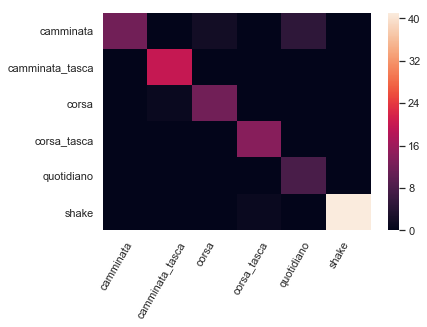

In [39]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

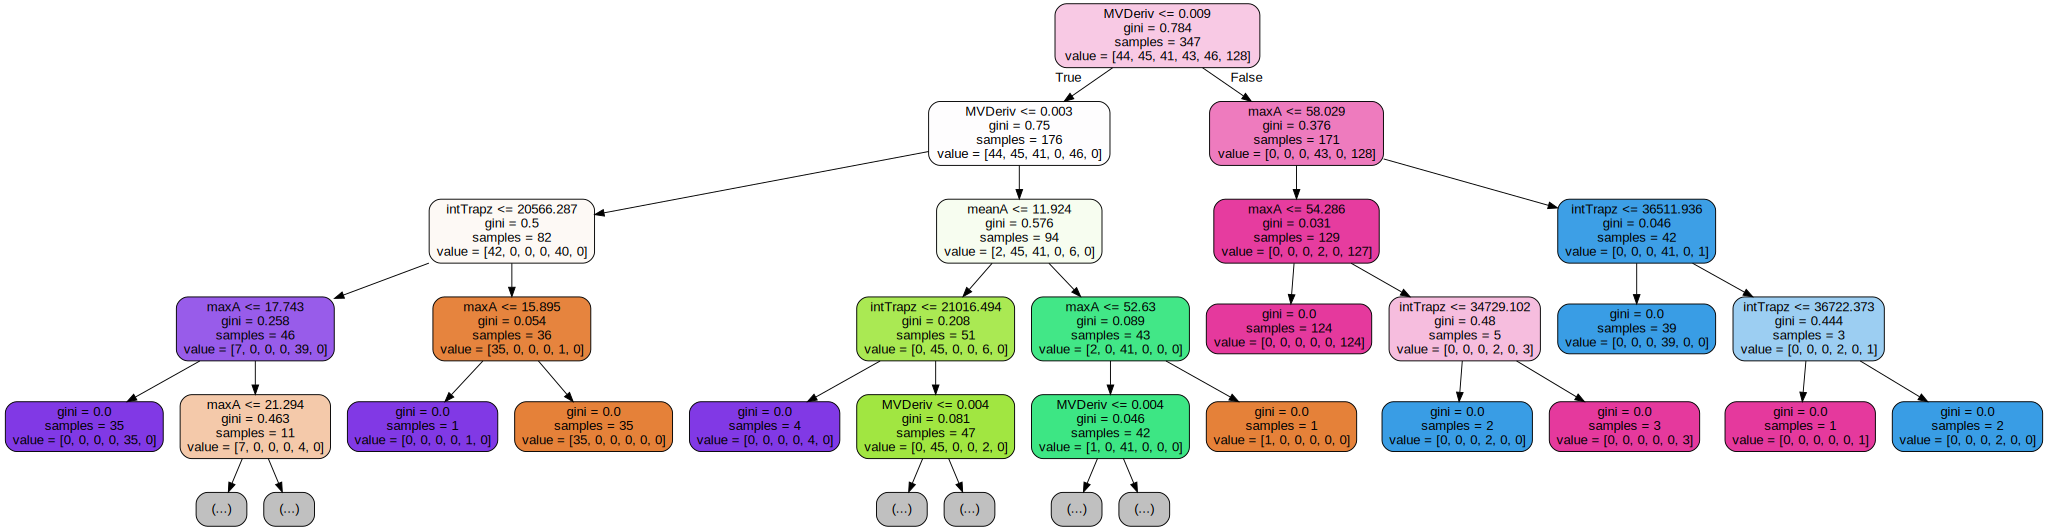

In [9]:
dot_data = export_graphviz(
    decision_tree=dtc.named_steps["tree"], 
    feature_names=espl.columns,
    max_depth=4,
    filled=True,
    rounded=True,
    node_ids=None
)
display(graphviz.Source(dot_data))

In [40]:
print("Profondità dell'albero allenato senza restrizioni: {}".format(dtc.named_steps["tree"].tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(X_train) // 2))

Profondità dell'albero allenato senza restrizioni: 7
Massimo numero minimo di osservazioni in una foglia: 173


In [41]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [12]:
2**8

256

In [42]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, 8),
    'tree__min_samples_leaf': 2 ** np.arange(8),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([1, 2, 3, 4, 5, 6, 7]), 'tree__min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128], dtype=int32)}]


In [43]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|███████████████████████████████████████| 56/56 [00:00<00:00, 165.73it/s]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.931034,4,1
1,0.931034,5,1
2,0.922414,4,2
3,0.922414,4,4
4,0.922414,4,8


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
51,0.431034,3,128
52,0.431034,4,128
53,0.431034,5,128
54,0.431034,6,128
55,0.431034,7,128


In [44]:
from funzioni import grafico_metrica_iperparametro

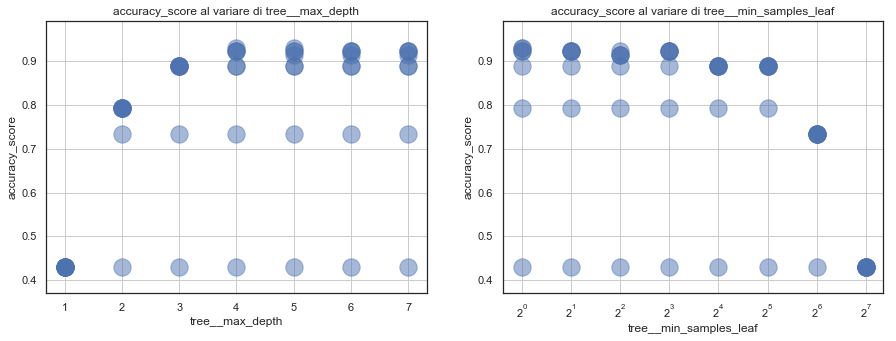

In [46]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "tree__max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "tree__min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

#probabilmente una profondità massima di 4 e un numero minimo di unità per foglia pari a 4 o 8 sono sufficienti
#(vedi tabella risultati prime due righe)

In [47]:
from funzioni import grafico_metrica_iperparametri

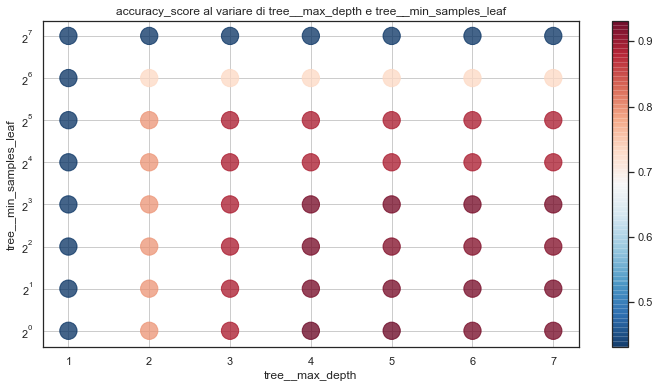

In [48]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "tree__max_depth", "tree__min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [49]:
risultati.head(12)

,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.931034,4,1
1,0.931034,5,1
2,0.922414,4,2
3,0.922414,4,4
4,0.922414,4,8
5,0.922414,5,2
6,0.922414,5,8
7,0.922414,6,1
8,0.922414,6,2
9,0.922414,6,8


In [20]:
from sklearn.impute import SimpleImputer

In [50]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))

Accuratezza DecisionTreeClassifier(): 92.2%
Accuratezza DecisionTreeClassifier(max_depth=4, min_samples_leaf=1): 93.1%


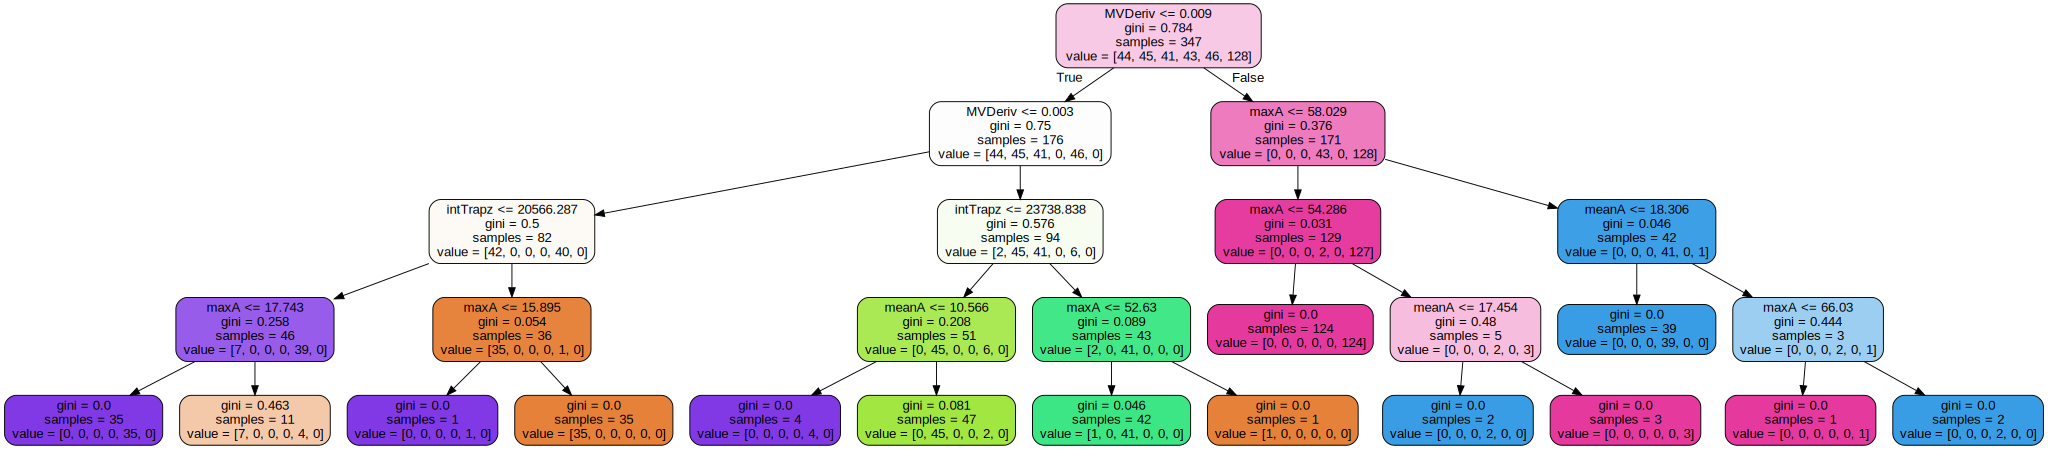

In [51]:
dot_data = export_graphviz(
    decision_tree=dtc_tun.named_steps["tree"],
    feature_names=espl.columns,
    filled=True,
    rounded=True,
    node_ids=None
)
display(graphviz.Source(dot_data))

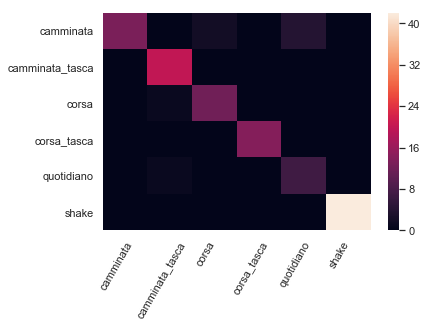

In [52]:
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

In [53]:
from funzioni.grafici import grafico_importanza_variabili

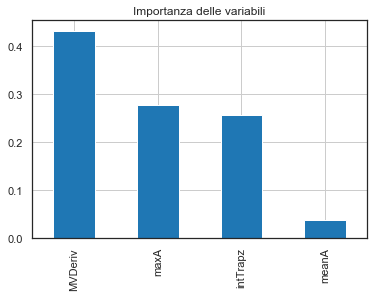

In [54]:
importanze = dtc_tun.named_steps["tree"].feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()